In [6]:
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

In [153]:
class MultiComp:
    def __init__(self, emb_size, n_comp, margin):
        self.pos = tf.placeholder(dtype=tf.float32, shape=[None, emb_size], name='pos_ph')
        self.neg = tf.placeholder(dtype=tf.float32, shape=[None, emb_size], name='neg_ph')
        self.lr = tf.placeholder(dtype=tf.float32, shape=[], name='learning_rate_ph')

        comp_init = np.random.randn(n_comp, emb_size) / np.sqrt(emb_size * n_comp)
        self.sense_comps = tf.Variable(comp_init, dtype=tf.float32, name='senses')
        
        # Attention
        mean_cont = tf.reduce_mean(self.pos, axis=0, keep_dims=True)
        mean_cont = tf.nn.l2_normalize(mean_cont, 1)  # 1 x 100
        
        norm_sens = tf.nn.l2_normalize(self.sense_comps, 1) # n_comp x 100
        
        att = tf.reduce_sum(mean_cont * norm_sens, axis=1, keep_dims=True)
        self.att = tf.nn.softmax(att, dim=0)
        word_emb = tf.reduce_sum(self.sense_comps * self.att, axis=0, keep_dims=True)
        
        
        # Cosine loss
        norm_pos = tf.nn.l2_normalize(self.pos, 1)
        norm_neg = tf.nn.l2_normalize(self.neg, 1)
        norm_word_emb = tf.nn.l2_normalize(word_emb, 1)
        
        pos_loss = tf.reduce_mean(tf.reduce_sum(norm_pos * norm_word_emb, axis=1))
        neg_loss = tf.reduce_mean(tf.reduce_sum(norm_neg * norm_word_emb, axis=1))
        
        self.loss = -pos_loss + neg_loss + 1e-3*tf.nn.l2_loss(self.sense_comps)
#         opt = tf.train.AdamOptimizer(self.lr)
        opt = tf.train.GradientDescentOptimizer(learning_rate=self.lr)
        self.train_op = opt.minimize(self.loss)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def train_on_sample(self, pos_samp, neg_samp, learning_rate):
        feed_dict = {self.pos: pos_samp, self.neg: neg_samp, self.lr: learning_rate}
        loss, att, _ = self.sess.run([self.loss, self.att, self.train_op], feed_dict)
        return loss, att

# Simple Test

In [154]:
net = MultiComp(100, 3, 0.1)

pos = np.random.randn(10, 100)
neg = np.random.randn(10, 100)

net.train_on_sample(pos, neg, 1e-3)

(0.07290364, array([[0.31967196],
        [0.33641776],
        [0.34391022]], dtype=float32))

# Train

In [2]:
from gensim.models import KeyedVectors
wv = KeyedVectors.load_word2vec_format("../models/model_big_one.vec", binary=False)

with open("../data/my_data/{}_out.txt".format('замок'), 'r') as f:
    lines = f.readlines()

In [3]:
def generate_triplet_batch(lines, context_max_len):

    voc_size = len(wv.vocab)
    for line in lines:
        line = line.split()
        embedd_p = []
        context = np.random.choice(line, context_max_len)
        for i, w in enumerate(context):
            try:
                embedd_p.append(wv[w])
            except KeyError:
                continue
        embedd_n = [wv[wv.index2word[i]] for i in np.random.random_integers(0, voc_size-1, len(embedd_p))]
        yield np.array(embedd_p), np.array(embedd_n)

In [155]:
w_emb = wv['замок'].reshape((1,100))
lr = 1e-2
n_comps = 2
net = MultiComp(100, n_comps, 0.1)


n_samples = len(lines)
n_context = 10 # number of words in the context
emb_dim = 100
atts = list()
epoch_num = 1
losses = []
for epoch in range(epoch_num):
    batch_gen = generate_triplet_batch(lines, context_max_len=n_context)
    pbar = tqdm_notebook(batch_gen, total = n_samples)
    print("epoch_num: ", epoch)
    for n, (sample_p, sample_n) in enumerate(pbar):
        if len(sample_p)==0:
            continue
        
        loss, att = net.train_on_sample(sample_p, sample_n, lr)
        atts.append(att)
        losses.append(loss)
        
        if n % 100 == 99:
            pbar.set_description("loss {:.3f}".format(float(np.mean(losses[-300:]))))

HBox(children=(IntProgress(value=0, max=111462), HTML(value='')))

epoch_num:  0


/home/fogside/virtualenvs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 202435 + 1) instead
  del sys.path[0]


# CENTROIDS

In [16]:
class MultiCompCentroids:
    def __init__(self, emb_size, n_comp, margin):
        self.pos = tf.placeholder(dtype=tf.float32, shape=[None, emb_size], name='pos_ph')
        self.neg = tf.placeholder(dtype=tf.float32, shape=[None, emb_size], name='neg_ph')
        self.lr = tf.placeholder(dtype=tf.float32, shape=[], name='learning_rate_ph')

        comp_init = np.random.randn(n_comp, emb_size) / np.sqrt(emb_size * n_comp)
        self.sense_comps = tf.Variable(comp_init, dtype=tf.float32, name='senses')
        self.centroids = tf.Variable(comp_init, dtype=tf.float32, name='centroids')
        
        # Attention
        mean_cont = tf.reduce_mean(self.pos, axis=0, keep_dims=True)
        mean_cont = tf.nn.l2_normalize(mean_cont, 1)  # 1 x 100
        
        norm_centroids = tf.nn.l2_normalize(self.centroids, 1) # n_comp x 100
        
        att = tf.reduce_sum(mean_cont * norm_centroids, axis=1, keep_dims=True)
        self.att = tf.nn.softmax(att, dim=0)
        
        max_index = tf.cast(tf.argmax(self.att)[0], tf.int32)
        print(max_index)
#         print(mean_cont)
#         print(self.centroids[max_index[0]])
        # Update centroids
        self.centroids[max_index].assign(mean_cont + self.centroids[max_index])
#         self.centroids[max_index[0]]+= mean_cont
        
        
#         word_emb = self.sense_comps * self.att, axis=0, keep_dims=True)
#         word_emb = tf.reduce_sum(self.sense_comps * self.att, axis=0, keep_dims=True)
        
        
        # Cosine loss
        norm_pos = tf.nn.l2_normalize(self.pos, 1)
        norm_neg = tf.nn.l2_normalize(self.neg, 1)
        norm_word_emb = tf.nn.l2_normalize(self.sense_comps[max_index], dim=0)
        
        pos_loss = tf.reduce_mean(tf.reduce_sum(norm_pos * norm_word_emb, axis=1))
        neg_loss = tf.reduce_mean(tf.reduce_sum(norm_neg * norm_word_emb, axis=1))
        
        self.loss = -pos_loss + neg_loss + 1e-3*tf.nn.l2_loss(self.sense_comps)
        opt = tf.train.AdamOptimizer(self.lr)
        self.train_op = opt.minimize(self.loss)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def train_on_sample(self, pos_samp, neg_samp, learning_rate):
        feed_dict = {self.pos: pos_samp, self.neg: neg_samp, self.lr: learning_rate}
        loss, att, _ = self.sess.run([self.loss, self.att, self.train_op], feed_dict)
        return loss, att

# Train

In [17]:
w_emb = wv['замок'].reshape((1,100))
lr = 1e-2
n_comps = 2
net = MultiCompCentroids(100, n_comps, 0.1)


n_samples = len(lines)
n_context = 10 # number of words in the context
emb_dim = 100
atts = list()
epoch_num = 1
losses = []
for epoch in range(epoch_num):
    batch_gen = generate_triplet_batch(lines, context_max_len=n_context)
    pbar = tqdm_notebook(batch_gen, total = n_samples)
    print("epoch_num: ", epoch)
    for n, (sample_p, sample_n) in enumerate(pbar):
        if len(sample_p)==0:
            continue
        
        loss, att = net.train_on_sample(sample_p, sample_n, lr)
        atts.append(att)
        losses.append(loss)
        
        if n % 100 == 99:
            pbar.set_description("loss {:.3f}".format(float(np.mean(losses[-300:]))))

Tensor("Cast:0", shape=(), dtype=int32)


HBox(children=(IntProgress(value=0, max=111462), HTML(value='')))

epoch_num:  0


/home/fogside/virtualenvs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 202435 + 1) instead
  del sys.path[0]


In [9]:
tf.__version__

'1.5.0'

# Visualize

### Sense vectors:

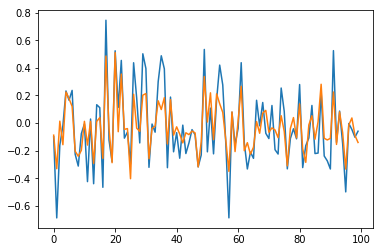

In [18]:
plt.plot(net.sess.run(net.sense_comps).T)
plt.show()

### Attention:

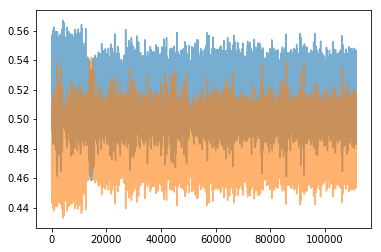

In [19]:
plt.plot(np.array(atts).squeeze(), alpha=0.6)
plt.show()

In [150]:
np.array(atts).squeeze().shape

(111462, 2)

### Losses:

In [22]:
def window_average(arr, w_len=10):
    return [np.mean(i) for i in np.split(arr, w_len,)]

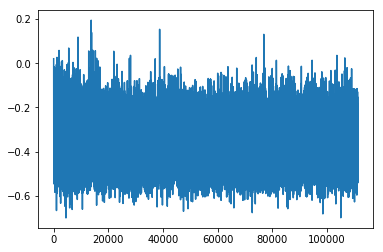

In [23]:
plt.plot(np.array(losses).squeeze())
plt.show()

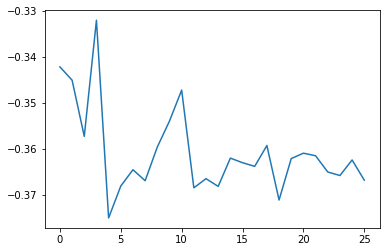

In [24]:
kek = np.array(losses).squeeze()
lol = window_average(kek, 26)
plt.plot(lol)
plt.show()

### Word similarity

In [25]:
vecs = net.sess.run(net.sense_comps)

In [28]:
vecs_c = net.sess.run(net.centroids)

In [31]:
wv.similar_by_vector(vecs_c\[0], 15)

[('кауз', 0.3415049612522125),
 ('эйлен', 0.3207801282405853),
 ('чимборасо', 0.313777893781662),
 ('нэйл', 0.3128708600997925),
 ('сноудон', 0.30594849586486816),
 ('хараламбос', 0.2939973771572113),
 ('вестиндский', 0.2933153510093689),
 ('эклиптический', 0.29323050379753113),
 ('туаз', 0.2932237684726715),
 ('командорский', 0.2917476296424866),
 ('полуостровной', 0.2914634644985199),
 ('гвинейский', 0.2900417447090149),
 ('бхактапур', 0.287021279335022),
 ('тидда', 0.28628042340278625),
 ('кобурн', 0.28340357542037964)]

In [32]:
wv.similar_by_vector(vecs_c[1], 20)

[('эстебан', 0.3258054256439209),
 ('эрефнаис', 0.30462515354156494),
 ('шинг', 0.30212900042533875),
 ('робба', 0.3004550039768219),
 ('айук', 0.29747673869132996),
 ('хессеф', 0.2927086353302002),
 ('редондо', 0.2900630831718445),
 ('инхаглик', 0.2878236770629883),
 ('акунья', 0.28108373284339905),
 ('хаймес', 0.28070375323295593),
 ('фаргаш', 0.2794108986854553),
 ('метлаэн', 0.27684059739112854),
 ('олькотт', 0.2763954699039459),
 ('онофрио', 0.2750706970691681),
 ('слинктон', 0.2744033634662628),
 ('льягас', 0.27244123816490173),
 ('бэзил', 0.27138784527778625),
 ('дэмьен', 0.26907235383987427),
 ('жабры', 0.26837828755378723),
 ('тэйл', 0.26794642210006714)]

# Weighted similarities

In [151]:
p = atts[-5:]
p

[array([[0.59179115],
        [0.40820885]], dtype=float32), array([[0.5793171 ],
        [0.42068288]], dtype=float32), array([[0.5958263],
        [0.4041736]], dtype=float32), array([[0.5720039 ],
        [0.42799604]], dtype=float32), array([[0.6178629 ],
        [0.38213718]], dtype=float32)]

In [152]:
for p in atts[-5:]:
    print(p)
    print("---")

[[0.59179115]
 [0.40820885]]
---
[[0.5793171 ]
 [0.42068288]]
---
[[0.5958263]
 [0.4041736]]
---
[[0.5720039 ]
 [0.42799604]]
---
[[0.6178629 ]
 [0.38213718]]
---


In [118]:
vecs.shape

(3, 100)

In [119]:
lol = np.sum(p*vecs, axis=0)
lol.shape

(100,)

In [116]:
wv.similar_by_vector(lol, 200)

[('от', 0.7358344197273254),
 ('который', 0.7354562282562256),
 ('из', 0.7353567481040955),
 ('как', 0.7331260442733765),
 ('один', 0.7306678891181946),
 ('во', 0.7306039333343506),
 ('со', 0.7302639484405518),
 ('самый', 0.7287554740905762),
 ('и', 0.7273545265197754),
 ('весь', 0.7255203723907471),
 ('когда', 0.7240930795669556),
 ('оно', 0.7240872383117676),
 ('в', 0.7235139012336731),
 ('тот', 0.7219510674476624),
 ('только', 0.7215321063995361),
 ('другой', 0.7211594581604004),
 ('оба', 0.7186580300331116),
 ('за', 0.7165206074714661),
 ('ни', 0.7142389416694641),
 ('перед', 0.7136077284812927),
 ('же', 0.7124976515769958),
 ('можно', 0.7106633186340332),
 ('место', 0.7095289826393127),
 ('так', 0.7073025703430176),
 ('треть', 0.7062292098999023),
 ('чем', 0.7061398029327393),
 ('мочь', 0.7058018445968628),
 ('большой', 0.705718457698822),
 ('то', 0.7053390145301819),
 ('нет', 0.7048940658569336),
 ('конец', 0.7036462426185608),
 ('раз', 0.7035396099090576),
 ('рано', 0.7030260562